# Glove to word vectors
[Glove](https://nlp.stanford.edu/projects/glove/) is an improved model of [word2vec](https://www.tensorflow.org/tutorials/word2vec) without losing too much context in the corps.

In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = 'glove.6B.50d.txt'

glove = {}
with open(filename, encoding='UTF-8') as f:
    for line in f:
        entities = line.split()
        word = entities[0]
        glove[word] = np.array(entities[1:], dtype=np.float32)

In [2]:
filename = 'glove.6B.50d.pkl'

In [4]:
with open(filename, 'wb') as f:
    pickle.dump(glove, f)
    
del glove

In [3]:
with open(filename, 'rb') as f:
    glove = pickle.load(f)

In [4]:
print(len(glove.keys()))

400000


# Keras's IMDB dataset
Note Keras's pre-processing of the words. It already set the start_char, oov_char, and index_from.

In [5]:
from keras.datasets import imdb

Using TensorFlow backend.


In [6]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [7]:
word_index = imdb.get_word_index()

In [8]:
word_freq = sorted(word_index, key=word_index.get)
idx2word = {word_index[w] : w for w in word_freq}

### Peek the IMDB comments

Note to subtract the index_from and start_char

In [9]:
' '.join([idx2word[i - 3] for i in x_train[0][1:]])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

### Set the vocab size to 5k most commonly used words

In [10]:
vocab_size = 5000

train = [np.array([i - 3 if i <= vocab_size - 1 + 3 else vocab_size - 1 for i in cmt[1:]]) for cmt in x_train]
test = [np.array([i - 3 if i <= vocab_size - 1 + 3 else vocab_size - 1 for i in cmt[1:]]) for cmt in x_test]

In [11]:
print(' '.join([idx2word[i] for i in train[0]]))
print('--------------')
print(' '.join([idx2word[i] for i in test[0]]))

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert bergman is an amazing actor and now the same being director bergman father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for bergman and would recommend it to everyone to watch and the fly bergman was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also bergman to the two little bergman that played the bergman of norman and paul they were just brilliant children are often left out of the bergman list i think because the stars that play them all grown up are such a big bergman for the whole film but these children are amazing and should be bergman f

### Padding each review to 500
Keras padding 0 at the beginning.

In [12]:
seq_len = 500

from keras.preprocessing.sequence import pad_sequences
train = pad_sequences(train, maxlen=seq_len, value=0)
test = pad_sequences(test, maxlen=seq_len, value=0)

In [13]:
print(train.shape)

(25000, 500)


### Create embedding matrix
Use the 400k glove vector to create an embedding matrix of IMDB movie review.

In [14]:
embedding_matrix = np.zeros((vocab_size, 50))

for i in range(1, vocab_size):
    w = idx2word[i]
    v = glove.get(w)
    if v is not None:
        embedding_matrix[i] = v

# Keras Embedding Layer
Note that we set the embedding layer to untrainable.

In [15]:
from keras.layers import Input, Flatten, Dropout, Dense, Embedding, Conv1D, MaxPooling1D, Activation
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM

In [16]:
embedding_layer = Embedding(
    vocab_size,
    50,
    weights = [embedding_matrix],
    input_length = seq_len,
    trainable=False # Not trainable
)

In [17]:
sequence_input = Input(shape=(seq_len,), dtype=np.int32)
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(.25)(embedded_sequences)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = Dropout(.25)(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.7)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           16064     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [19]:
history = model.fit(train, y_train, epochs=10, validation_data=(test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 14s - loss: 0.6505 - acc: 0.6002 - val_loss: 0.4918 - val_acc: 0.7863
Epoch 2/10
25000/25000 [==============================] - 13s - loss: 0.4890 - acc: 0.7714 - val_loss: 0.4232 - val_acc: 0.8155
Epoch 3/10
25000/25000 [==============================] - 13s - loss: 0.4470 - acc: 0.7969 - val_loss: 0.4022 - val_acc: 0.8282
Epoch 4/10
25000/25000 [==============================] - 13s - loss: 0.4271 - acc: 0.8074 - val_loss: 0.3852 - val_acc: 0.8314
Epoch 5/10
25000/25000 [==============================] - 13s - loss: 0.4128 - acc: 0.8154 - val_loss: 0.3893 - val_acc: 0.8383
Epoch 6/10
25000/25000 [==============================] - 13s - loss: 0.3958 - acc: 0.8236 - val_loss: 0.3694 - val_acc: 0.8405
Epoch 7/10
25000/25000 [==============================] - 13s - loss: 0.3829 - acc: 0.8302 - val_loss: 0.3673 - val_acc: 0.8449
Epoch 8/10
25000/25000 [==============================

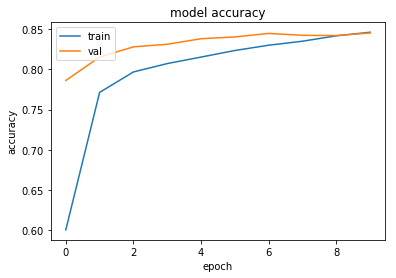

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()